In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
import sys
sys.path.append("/home/jovyan/PACEfun")
import helper
from dask.distributed import Client
import importlib, helper; importlib.reload(helper)
# ToDo Add quality filter^


: 

In [2]:
client = Client()
auth = earthaccess.login("login.netrc")


In [3]:
# --- TIME ---

tspan = ("2024-03-01 00:00", "2025-09-01 00:00") 

# --- REGION ---
df = pd.read_csv("/home/jovyan/PACEfun/balkan_plants.csv")

# Extract latitude and longitude
coords = df[['Latitude', 'Longitude']].values

# Convert to radians for haversine
coords_rad = np.radians(coords)

# Compute the distance matrix using haversine
dist_matrix = haversine_distances(coords_rad)

# Define epsilon in radians (e.g., ~100 km)
earth_radius_km = 6371
max_distance_km = 50
epsilon = max_distance_km / earth_radius_km

# Apply DBSCAN with precomputed distances
db = DBSCAN(eps=epsilon, min_samples=1, metric='precomputed')
clusters = db.fit_predict(dist_matrix)

# Add cluster labels to the DataFrame
df['Cluster'] = clusters

cluster_means = df[df['Cluster'] != -1].groupby('Cluster')[['Latitude', 'Longitude']].mean().reset_index()

# Group by cluster and print the results
print("Clustered Coal Plants:")
for cluster_id in sorted(df['Cluster'].unique()):
    if cluster_id == -1:
        print("\nNoise (unclustered):")
    else:
        print(f"\nCluster {cluster_id}:")
        # Get mean coordinates for this cluster
        mean_coords = cluster_means[cluster_means['Cluster'] == cluster_id]
        if not mean_coords.empty:
            mean_lat = mean_coords['Latitude'].iloc[0]
            mean_lon = mean_coords['Longitude'].iloc[0]
            print(f"Mean Coordinates: Latitude = {mean_lat:.6f}, Longitude = {mean_lon:.6f}")
    cluster_df = df[df['Cluster'] == cluster_id]
    for _, row in cluster_df.iterrows():
        print(f"- {row['Name']} ({row['Country']}) at ({row['Latitude']}, {row['Longitude']})")


Clustered Coal Plants:

Cluster 0:
Mean Coordinates: Latitude = 40.401946, Longitude = 21.856229
- Agios Dimitrios power station (Greece) at (40.394185, 21.924886)
- Ptolemaïda power station (Greece) at (40.409707, 21.787573)

Cluster 1:
Mean Coordinates: Latitude = 44.575826, Longitude = 20.225978
- Nikola Tesla power station (Serbia) at (44.671341, 20.158418)
- Kolubara A power station (Serbia) at (44.480312, 20.293538)

Cluster 2:
Mean Coordinates: Latitude = 42.446471, Longitude = 23.055765
- Republika power station (Bulgaria) at (42.607124, 23.078699)
- Bobov Dol power station (Bulgaria) at (42.285818, 23.03283)

Cluster 3:
Mean Coordinates: Latitude = 42.684787, Longitude = 21.070962
- Kosovo A power station (Kosovo) at (42.676454, 21.085922)
- Kosovo B power station (Kosovo) at (42.69312, 21.056002)

Cluster 4:
Mean Coordinates: Latitude = 41.058320, Longitude = 21.484266
- Bitola power station (North Macedonia) at (41.05832, 21.484266)

Cluster 5:
Mean Coordinates: Latitude = 4

In [12]:
region = (12.572136,35.345655,30.413933,49.060595) # bbox balkan region

results_spx = earthaccess.search_data(
short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
cloud_hosted=True,
bounding_box=region,
temporal=tspan,
count=200,
)
paths_spx = earthaccess.open(results_spx)

wv = 550
wv_idx = helper.get_wv_idx(paths_spx[0], wv)
crs, shape_tmp, transform_tmp = helper.crs_template(paths_spx[0], "aot", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = helper.grid_aligned_subset(region, transform_tmp, shape_tmp)


kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_spx, preprocess=helper.time_from_attr, **kwargs)
futures = client.map(
    helper.grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="aot",
    wv_idx=wv_idx
)
da_spx_aod = xr.combine_nested(client.gather(futures), concat_dim="time")
da_spx_aod["time"] = attrs["time"]


kwargs_ae = {"combine": "nested", "concat_dim": "time"}
attrs_ae = xr.open_mfdataset(paths_spx, preprocess=helper.time_from_attr, **kwargs_ae)
futures_ae = client.map(
    helper.grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="angstrom_440_670",
    wv_idx=None
)
da_spx_ae = xr.combine_nested(client.gather(futures_ae), concat_dim="time")
da_spx_ae["time"] = attrs_ae["time"]

QUEUEING TASKS | :   0%|          | 0/200 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/200 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/200 [00:00<?, ?it/s]

It takes 4:25 for 200 colocation.

In [ ]:
factors = [2,4,6,12,24,48, 96, 192]

aod_mean = []
aod_std = []
ae_mean = []
ae_std = []
        

def area_plot(da, lon_res, lat_res, mid, factor=1):


    lon = da.longitude
    lat = da.latitude

    radius = factor * lat_res  # radius in degrees (approx)

    # check if da has any non-NaN values
    if not da.notnull().any():
        return None

    da_filtered = da.where(
        ((lat - mid[1])**2 + (lon - mid[0])**2) < radius**2,
        #( np.abs(lat - mid[1]) < radius ) & ( np.abs(lon - mid[0]) < 0.5 ) ,
        drop=True
    )
    
    
    # check if da has any non-NaN values
    if not da_filtered.notnull().any():
        return None
    
    return da_filtered

for _, row in cluster_means.iterrows():
    
    aod_mean_f = []
    aod_std_f = []
    ae_mean_f = []
    ae_std_f = []
        
    cluster_id = int(row['Cluster'])
    
    mean_lat = row['Latitude']
    mean_lon = row['Longitude']
    print(f"\nCluster {cluster_id}:")
    print(f"Mean Coordinates: Latitude = {mean_lat:.6f}, Longitude = {mean_lon:.6f}")


    mid = ( mean_lon, mean_lat )
    
    # Keep your original convention
    lat_res = np.abs(transform[0])
    lon_res = np.abs(transform[4])

    for f in factors:        
        da_f = area_plot(da_spx_aod, lon_res, lat_res, mid, f)
        if da_f is None:
                        
            aod_mean_f.append(np.nan)
            aod_std_f.append(np.nan)

            ae_mean_f.append(np.nan)
            ae_std_f.append(np.nan)

            continue

        # Spatial mean & std per time step
        mean_ts = da_f.mean(dim=["longitude", "latitude"]).mean(dim="time").values
        std_ts  = da_f.std(dim=["longitude", "latitude"]).mean(dim="time").values
        
        
        aod_mean_f.append(mean_ts)
        aod_std_f.append(std_ts)
        
        da_f = area_plot(da_spx_ae, lon_res, lat_res, mid, f)
        
        # Spatial mean & std per time step
        mean_ts = da_f.mean(dim=["longitude", "latitude"]).mean(dim="time").values
        std_ts  = da_f.std(dim=["longitude", "latitude"]).mean(dim="time").values

        ae_mean_f.append(mean_ts)
        ae_std_f.append(std_ts)

    aod_mean.append(aod_mean_f)
    aod_std.append(aod_std_f)
    ae_mean.append(ae_mean_f)
    ae_std.append(ae_std_f)


Cluster 0:
Mean Coordinates: Latitude = 40.401946, Longitude = 21.856229


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 1:
Mean Coordinates: Latitude = 44.575826, Longitude = 20.225978


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 2:
Mean Coordinates: Latitude = 42.446471, Longitude = 23.055765


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 3:
Mean Coordinates: Latitude = 42.684787, Longitude = 21.070962


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 4:
Mean Coordinates: Latitude = 41.058320, Longitude = 21.484266


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 5:
Mean Coordinates: Latitude = 44.602243, Longitude = 18.787479


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 6:
Mean Coordinates: Latitude = 44.089633, Longitude = 18.113865


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 7:
Mean Coordinates: Latitude = 43.172137, Longitude = 18.511555


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 8:
Mean Coordinates: Latitude = 42.185458, Longitude = 26.015139


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 9:
Mean Coordinates: Latitude = 44.723674, Longitude = 21.171605


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 10:
Mean Coordinates: Latitude = 44.641098, Longitude = 23.451097


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 11:
Mean Coordinates: Latitude = 41.582000, Longitude = 21.000000


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 12:
Mean Coordinates: Latitude = 46.372300, Longitude = 15.053400


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 13:
Mean Coordinates: Latitude = 45.136764, Longitude = 14.162702


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt


Cluster 14:
Mean Coordinates: Latitude = 37.417449, Longitude = 22.107892


/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dt

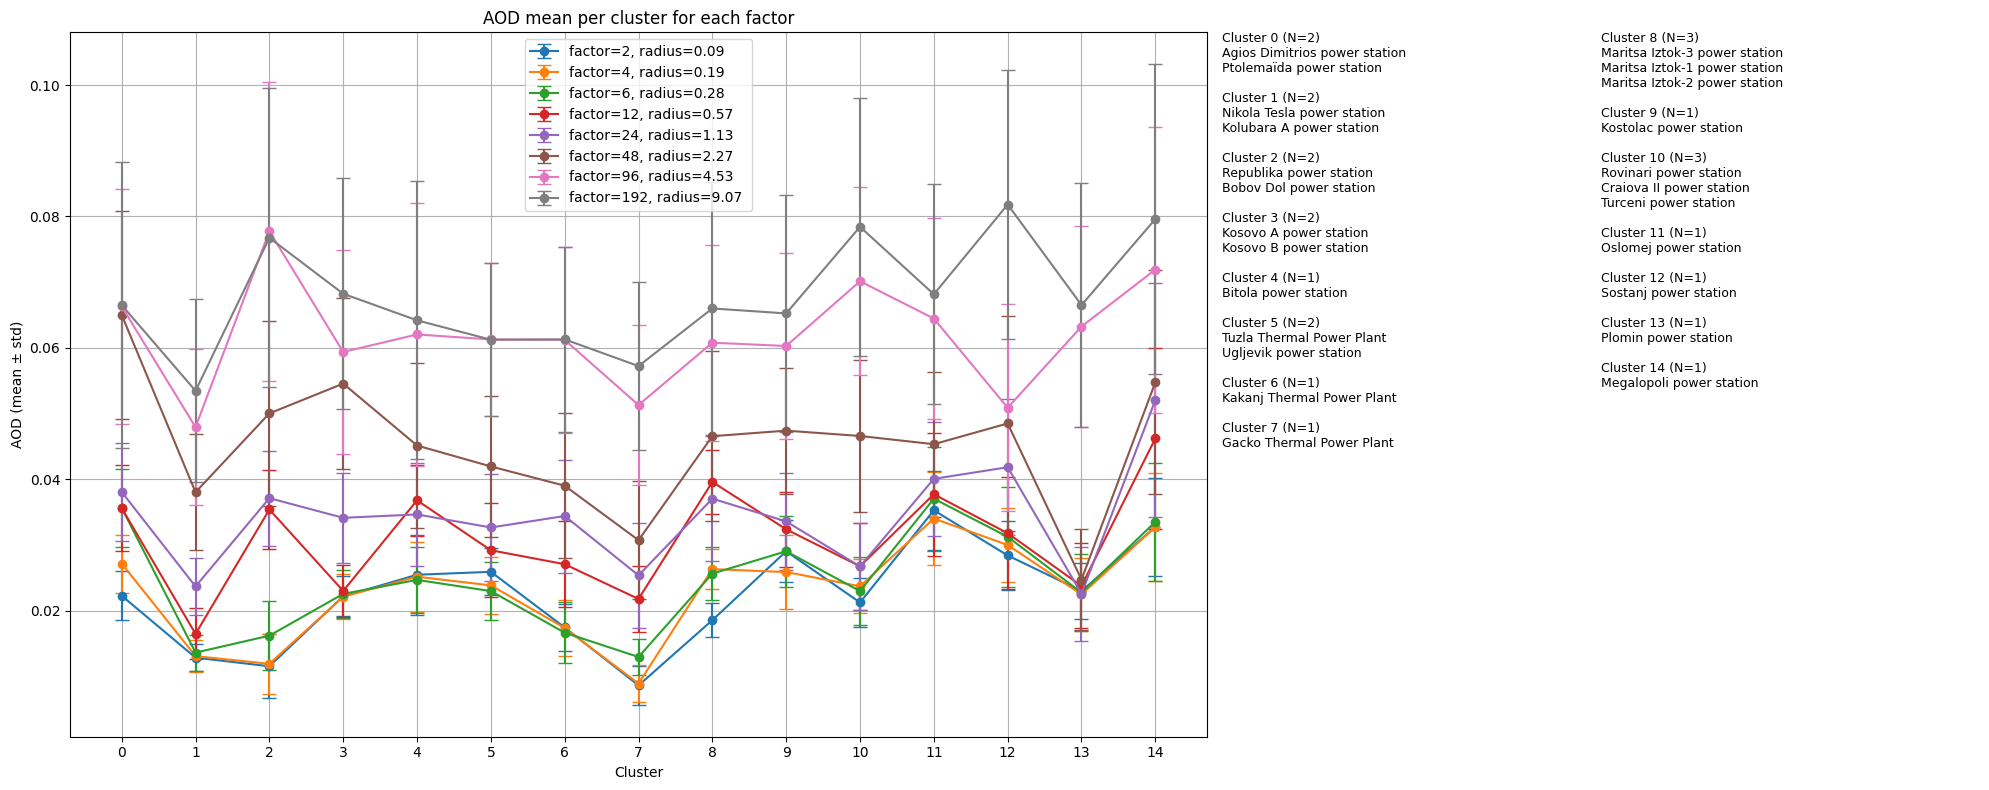

In [49]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

# Group plant names per cluster (ignore noise = -1)
cluster_groups = (
    df[df['Cluster'] != -1]
    .groupby('Cluster')['Name']
    .apply(list)
    .sort_index()
)

clusters = cluster_groups.index

# ----- Create a 1x2 layout: left = plot, right = text -----
fig = plt.figure(figsize=(20,8))  # bigger figure
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])  # give plot more space

# ---- Left: Plot ----
ax0 = plt.subplot(gs[0])
for f_idx, f in enumerate(factors):
    means = [aod_mean[c][f_idx] for c in clusters]
    stds  = [aod_std[c][f_idx] for c in clusters]
    
    ax0.errorbar(
        clusters,
        means,
        yerr=stds,
        marker="o",
        capsize=5,
        label=f"factor={f}, radius={f * np.abs(transform[0]):.2f} "
    )

ax0.set_xticks(clusters)
ax0.set_xticklabels([str(c) for c in clusters])
ax0.set_xlabel("Cluster")
ax0.set_ylabel("AOD (mean ± std)")
ax0.set_title("AOD mean per cluster for each factor")
ax0.legend()
ax0.grid()

# ---- Right: Text info with two columns ----
ax1 = plt.subplot(gs[1])
ax1.axis("off")

# prepare cluster text blocks
cluster_texts = []
for c in clusters:
    names = "\n".join(cluster_groups[c])  # one name per line
    cluster_texts.append(f"Cluster {c} (N={len(cluster_groups[c])})\n{names}\n")

# split into two columns
mid = math.ceil(len(cluster_texts)/2)
col1 = "\n".join(cluster_texts[:mid])
col2 = "\n".join(cluster_texts[mid:])

ax1.text(0.0, 1, col1, va="top", ha="left", fontsize=9)
ax1.text(0.5, 1, col2, va="top", ha="left", fontsize=9)

plt.tight_layout()
plt.show()

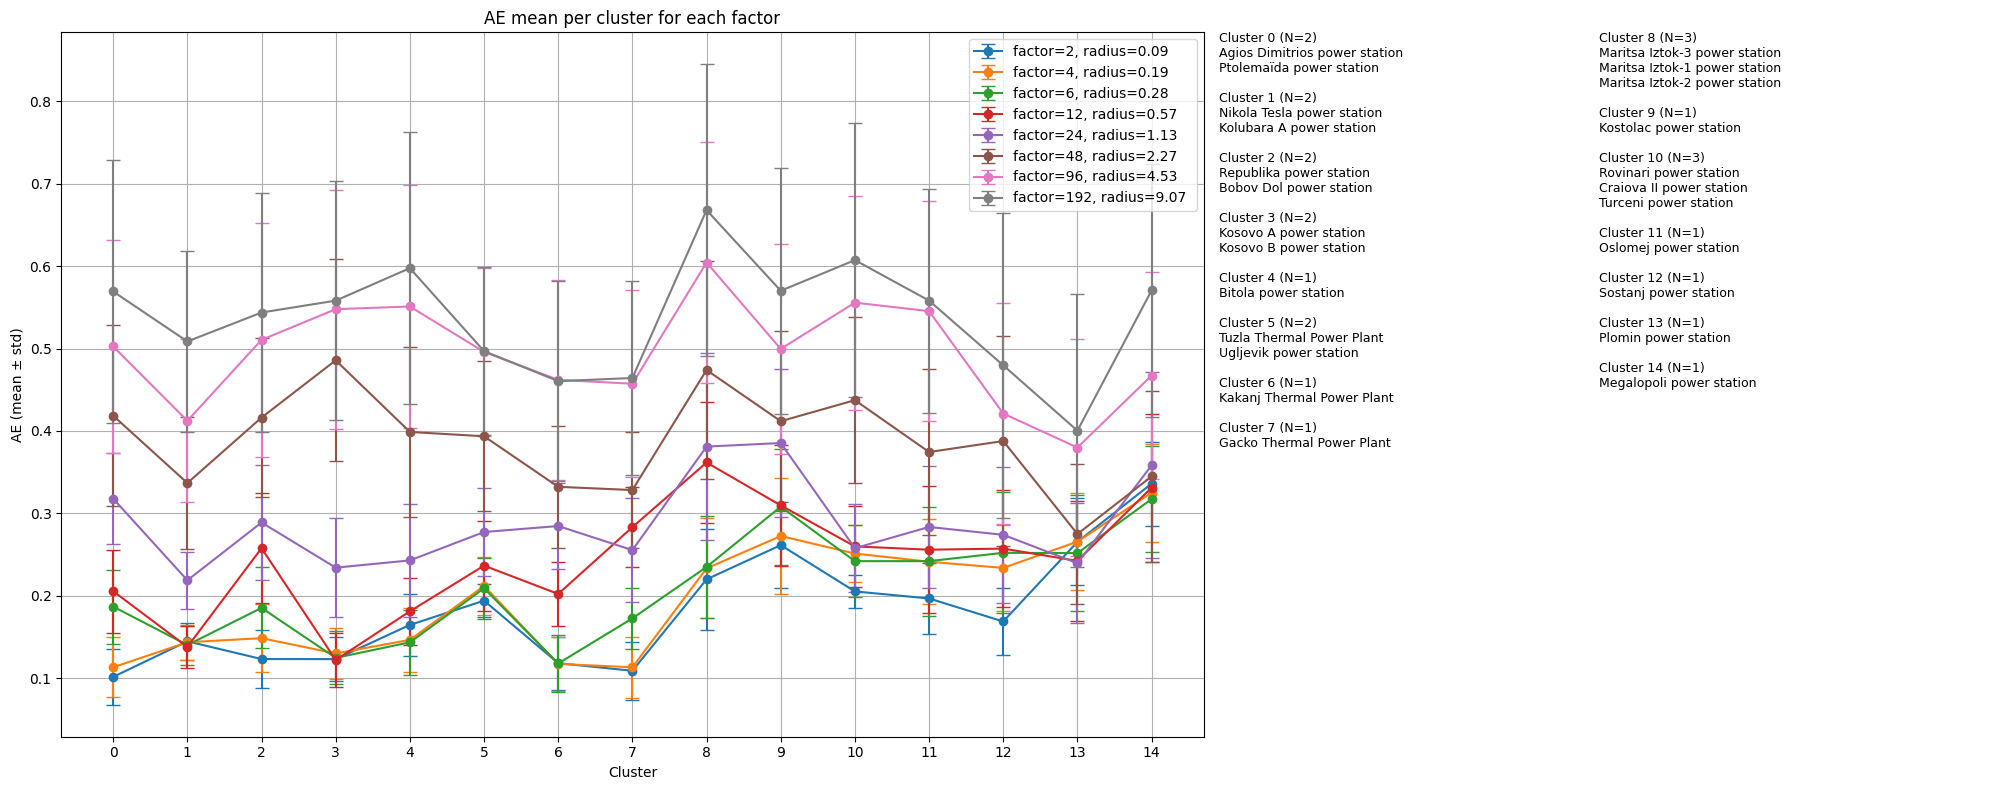

In [51]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

# Group plant names per cluster (ignore noise = -1)
cluster_groups = (
    df[df['Cluster'] != -1]
    .groupby('Cluster')['Name']
    .apply(list)
    .sort_index()
)

clusters = cluster_groups.index

# ----- Create a 1x2 layout: left = plot, right = text -----
fig = plt.figure(figsize=(20,8))  # bigger figure
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])  # give plot more space

# ---- Left: Plot ----
ax0 = plt.subplot(gs[0])
for f_idx, f in enumerate(factors):
    means = [ae_mean[c][f_idx] for c in clusters]
    stds  = [ae_std[c][f_idx] for c in clusters]
    
    ax0.errorbar(
        clusters,
        means,
        yerr=stds,
        marker="o",
        capsize=5,
        label=f"factor={f}, radius={f * np.abs(transform[0]):.2f} "
    )

ax0.set_xticks(clusters)
ax0.set_xticklabels([str(c) for c in clusters])
ax0.set_xlabel("Cluster")
ax0.set_ylabel("AE (mean ± std)")
ax0.set_title("AE mean per cluster for each factor")
ax0.legend()
ax0.grid()

# ---- Right: Text info with two columns ----
ax1 = plt.subplot(gs[1])
ax1.axis("off")

# prepare cluster text blocks
cluster_texts = []
for c in clusters:
    names = "\n".join(cluster_groups[c])  # one name per line
    cluster_texts.append(f"Cluster {c} (N={len(cluster_groups[c])})\n{names}\n")

# split into two columns
mid = math.ceil(len(cluster_texts)/2)
col1 = "\n".join(cluster_texts[:mid])
col2 = "\n".join(cluster_texts[mid:])

ax1.text(0.0, 1, col1, va="top", ha="left", fontsize=9)
ax1.text(0.5, 1, col2, va="top", ha="left", fontsize=9)

plt.tight_layout()
plt.show()

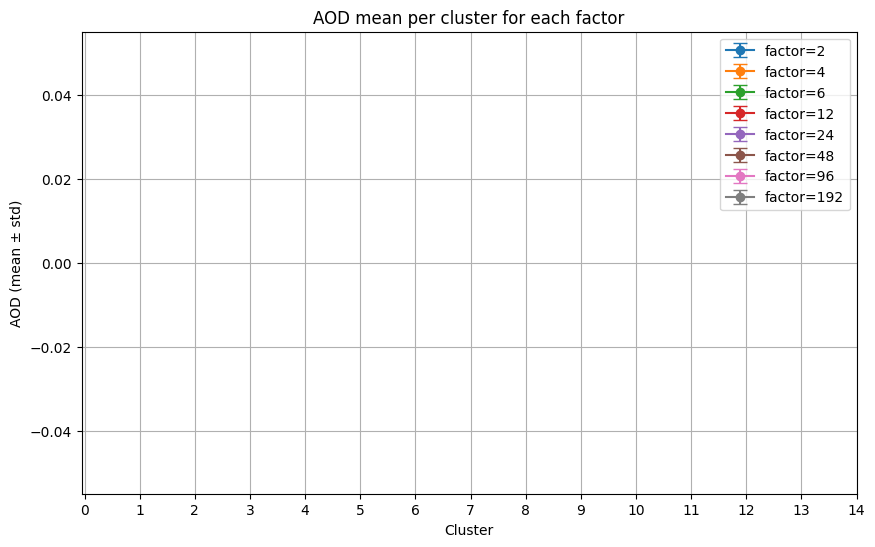

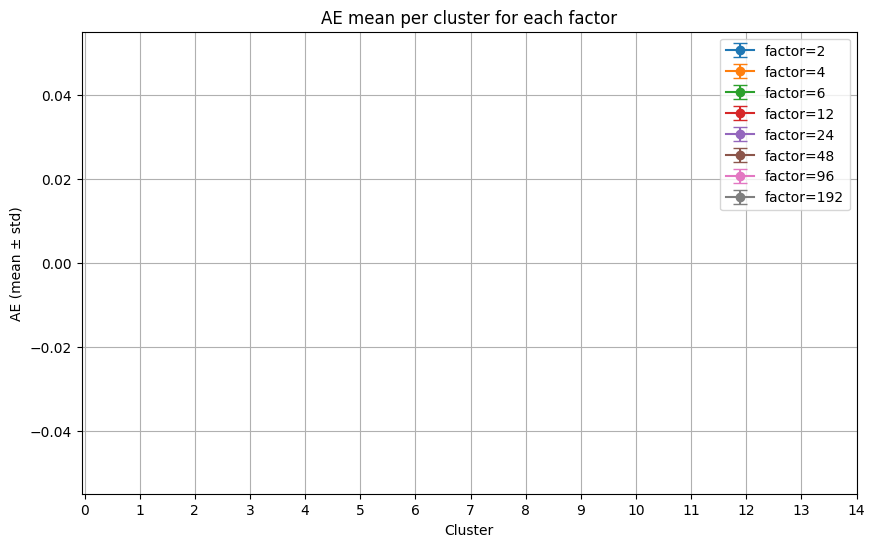

In [47]:
import numpy as np
import matplotlib.pyplot as plt

clusters = range(len(aod_mean))

# AOD
plt.figure(figsize=(10,6))
for f_idx, f in enumerate(factors):
    means = [aod_mean[c][f_idx] for c in clusters]
    stds  = [aod_std[c][f_idx] for c in clusters]
    
    plt.errorbar(
        clusters,
        means,
        yerr=stds,
        marker="o",
        capsize=5,
        label=f"factor={f}"
    )

plt.xticks(clusters, [f"{c}" for c in clusters])
plt.xlabel("Cluster")
plt.ylabel("AOD (mean ± std)")
plt.title("AOD mean per cluster for each factor")
plt.legend()
plt.grid()
plt.show()

# AE
plt.figure(figsize=(10,6))
for f_idx, f in enumerate(factors):
    means = [ae_mean[c][f_idx] for c in clusters]
    stds  = [ae_std[c][f_idx] for c in clusters]
    
    plt.errorbar(
        clusters,
        means,
        yerr=stds,
        marker="o",
        capsize=5,
        label=f"factor={f}"
    )

plt.xticks(clusters, [f"{c}" for c in clusters])
plt.xlabel("Cluster")
plt.ylabel("AE (mean ± std)")
plt.title("AE mean per cluster for each factor")
plt.legend()
plt.grid()
plt.show()
